# SIGNAL PROCESSING TP6 - M2 AI
## To Do: image denoising in wavelet domain

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

---

## IMPORT

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pywt
import tqdm
from numpy import linalg
from numpy import random




from nt_toolbox.general import *
from nt_toolbox.signal import *

In [2]:
original_image = cv2.imread('barbara.jpg', cv2.IMREAD_GRAYSCALE)
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

np.random.seed(42)

SNR_LEVELS = [0, 5, 10, 15, 30]

# Different probabilities for Bernoulli mask
P_VALUES = [0.1, 0.5, 0.9]

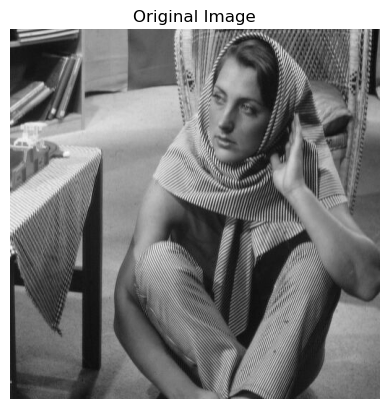

In [61]:
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

## Simulate various inpaintings

### Generate a random binary matrix A of the same size of the image, with a parameter p controling the bernoulli law

In [8]:
p=0.6
A=np.random.binomial(1, p, size=original_image.shape)
A

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

### Add white gaussian noise to the image (at various levels)

In [9]:
def add_noise(signal, snr_db):
    # Compute the variance of the noise
    signal_variance = np.var(signal)
    calculated_noise_variance = signal_variance / np.power(10, snr_db / 10)
    calculated_noise_std = np.sqrt(calculated_noise_variance)
    
    # Introduce noise to the original image
    generated_noise = np.random.normal(0, calculated_noise_std, np.shape(signal))
    distorted_signal = signal + generated_noise
    
    return distorted_signal

### Generate the direct problem y=Ax+b (where x is the original image)

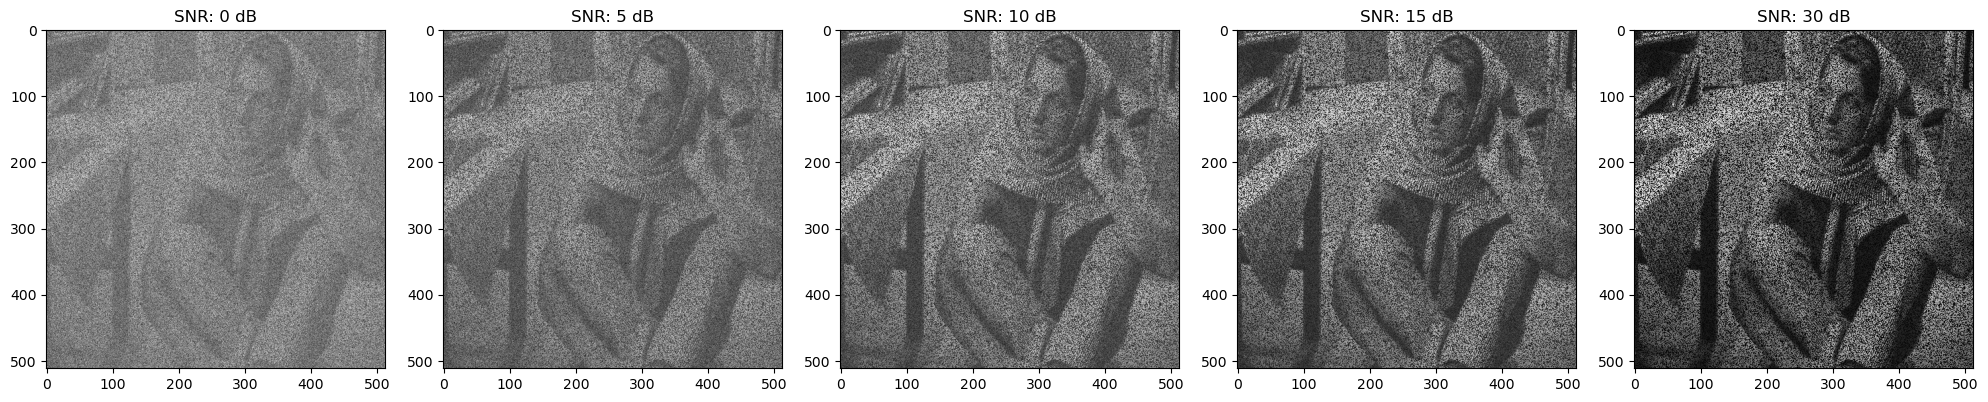

In [10]:
corrupted_images_dict = {SNR: None for SNR in SNR_LEVELS}
#Compute the inpainting:
inpainting_image= original_image*A

# Corrupt the images using Gaussian noise
for snr in SNR_LEVELS:
        # Compute the direct problem
        corrupted_img = add_noise(inpainting_image, snr)
        corrupted_images_dict[snr] = corrupted_img

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i, SNR in enumerate(SNR_LEVELS):
    ax = axes[i]
    
    # Display the image using imshow
    ax.imshow(corrupted_images_dict[SNR], cmap='gray')
    ax.set_title(f"SNR: {SNR} dB")


plt.tight_layout()
plt.show()

---
## Estimate x using the sparse approach

To estimate $ x $ from its corrupted version $ y $ using a sparse approach in the wavelet domain, we exploit the fact that images tend to have a sparse representation in the wavelet domain.  

Mathematically, this can be formulated as:

$$
\hat{x} = \arg\min_x \frac{1}{2} \Vert Ax - y \Vert_2^2 + \lambda \Vert Wx \Vert_1
$$

Where:

- $ A $ is the degradation operator (in our case, the Bernoulli mask).
- $ y $ is the observed degraded image.
- $ W $ is the wavelet transform.
- $ \lambda $ is a regularization parameter that balances between the data fidelity term and the sparsity-inducing term.
- The $ L_1 $ norm (denoted by $ \Vert \cdot \Vert_1 $) promotes sparsity in the wavelet coefficients.

### 1 FISTA Soft Thresholding using Numerical Tours wavelet orthogonal tranform

We are going to Implement the FISTA Algorithm while using an orthogonal wavelet basis Psi

In [21]:
# import wavelet transform function from numerical tour
from nt_toolbox.perform_wavelet_transf import *
n=512
# from Numerical Tours:
Jmax = np.log2(n)-1
Jmin = (Jmax-3)

Here, Psi is the wavelet transform 

In [11]:
Psi = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=0)
PsiS = lambda f: perform_wavelet_transf(f, Jmin, +1, ti=0)

Defining a function for soft thresholding:

In [12]:
SoftThresh = lambda x, T: x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))

Soft Thresholding operator in base Psi: Computed by thresholding the coefficients and then applying Psi

In [13]:
SoftThreshPsi = lambda f, T: Psi(SoftThresh(PsiS(f), T))

In [84]:
def FISTA_SoftThresh(snr, iterations=100, lambd=0.03):
    """
    Apply FISTA algorithm for denoising.

    Parameters:
    - snr: Signal-to-noise ratio
    - iterations: Number of iterations
    - lambd: Regularization parameter

    Returns:
    - denoised_image: Denoised image
    """
    # Used to monitor the decay of energy that we are minimizing
    energy = [] 
    
    # Parameter Initialization
    alpha = np.zeros_like(original_image)
    z = np.zeros_like(original_image)

    for i in range(iterations):
        a = SoftThreshPsi(z + PsiS(A * (corrupted_images_dict[snr] - A * Psi(z))), lambd)
        z = a + (i / (i + 5)) * (a - alpha)
        alpha = a

        # Compute and store the energy
        current_energy = 1/2 * np.linalg.norm(corrupted_images_dict[snr] - A * Psi(alpha), "fro")**2 + lambd * np.sum(abs(alpha))
        energy.append(current_energy)

        # Denoised image
        denoised_image = Psi(alpha)

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(f"SNR={snr}")
    axs[0].imshow(denoised_image, cmap='gray')
    axs[1].plot(energy, linewidth=2)
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Energy")

    return denoised_image


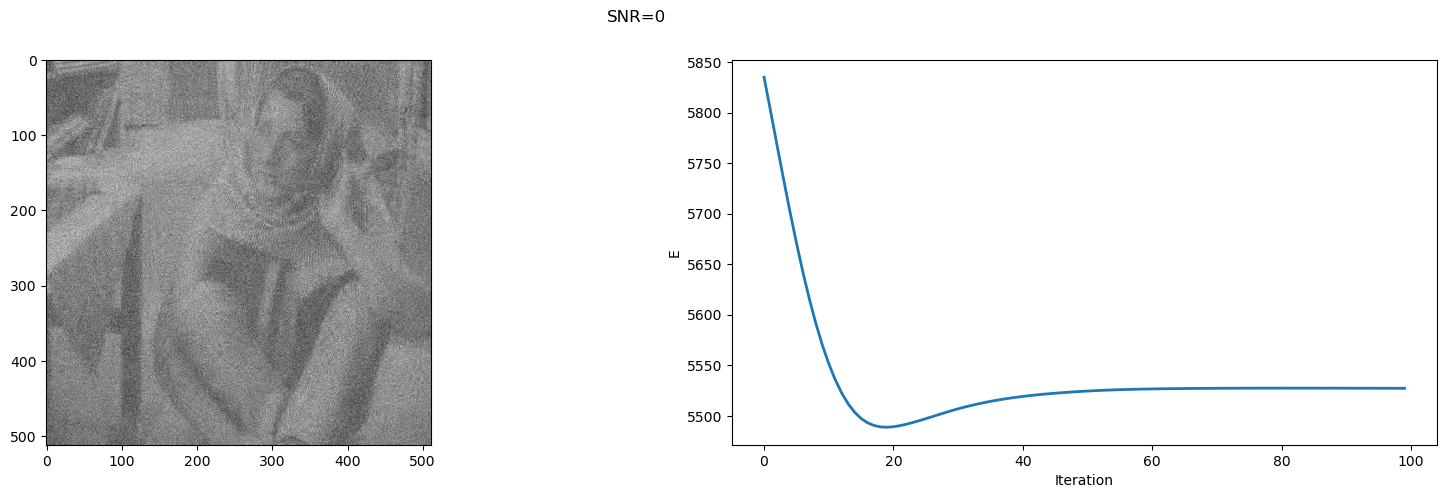

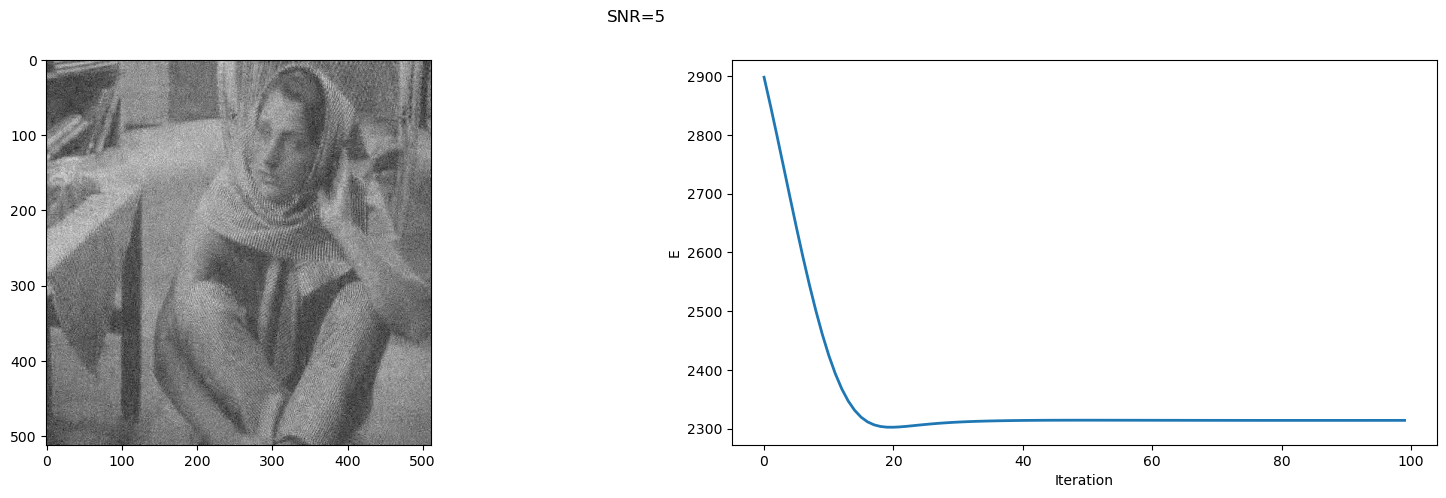

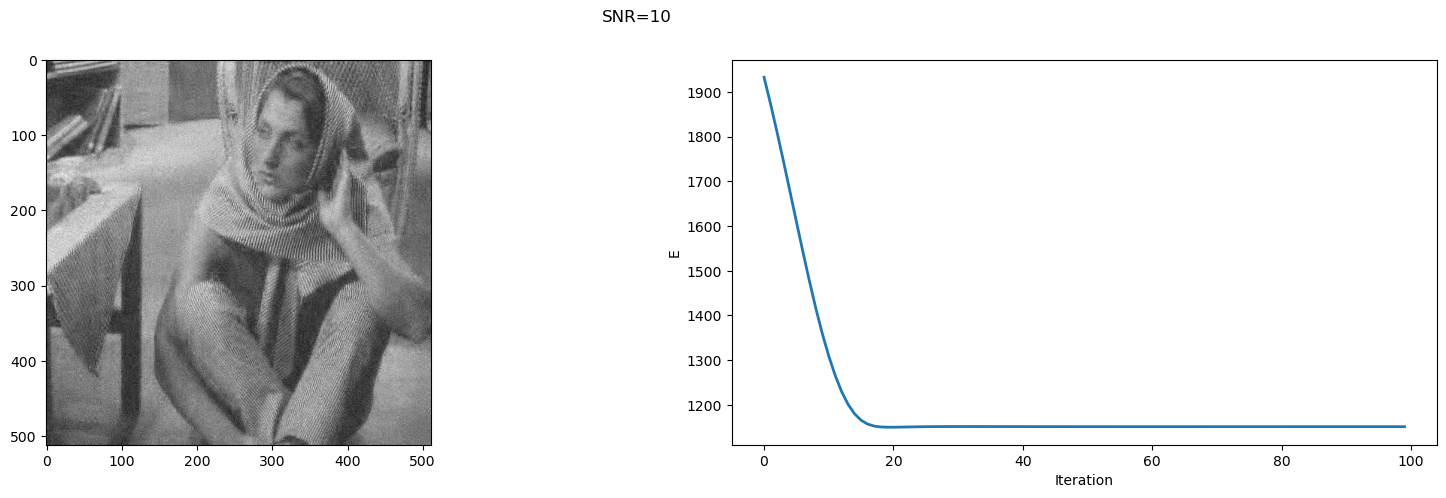

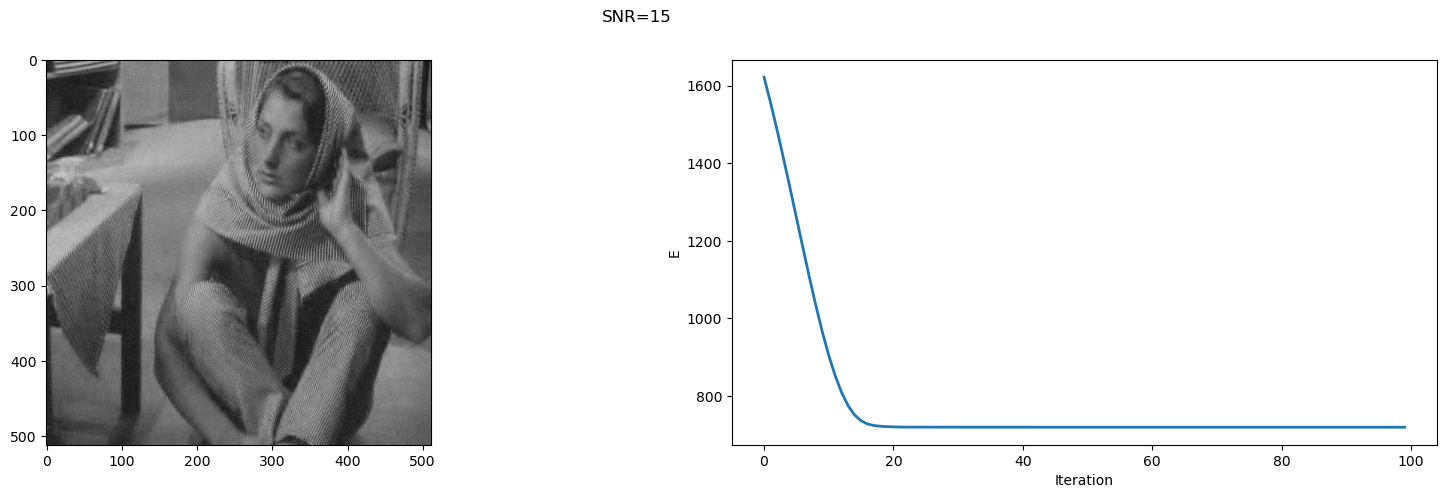

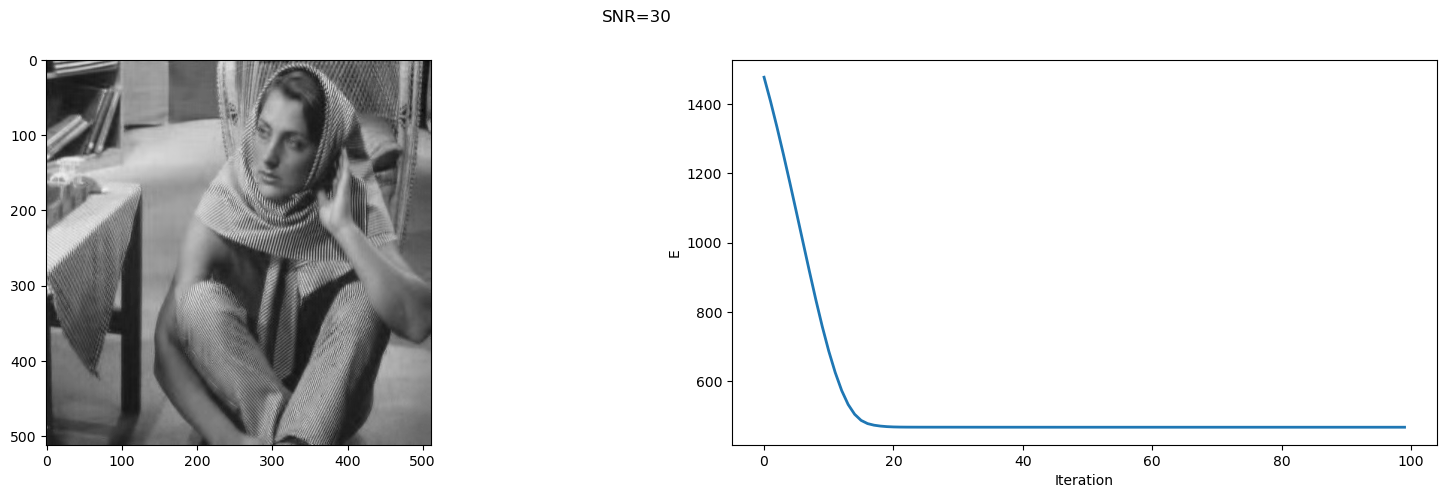

In [83]:
for snr in SNR_LEVELS:
    FISTA_SoftThresh(snr)

We can see that for all the images the FISTA Algorithm seems to converge after the 20th iteration. 

### 2 Inpainting using Translation Invariant Wavelet Sparsity: A numerical tours implementation

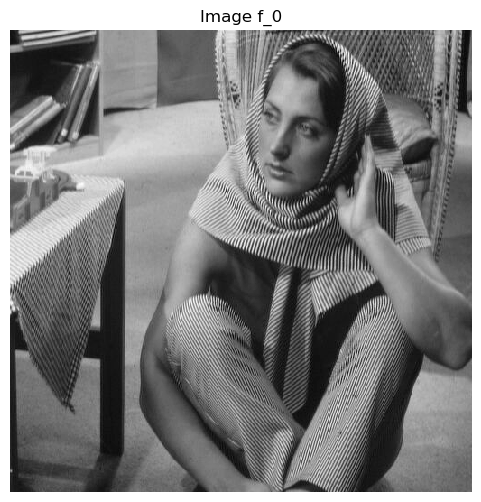

In [31]:
n = 512
f0 = load_image("barbara.jpg")
f0 = rescale(f0[256-n//2:256+n//2,256-n//2:256+n//2])
plt.figure(figsize = (6,6))
imageplot(f0, 'Image f_0')

In [28]:
# From numerical tours tutorial:
# Removed pixel percentage
rho = .7

# We construct a mask Omega with random pixels:
Omega = np.zeros([n, n])
sel = random.permutation(n**2)
np.ravel(Omega)[sel[np.arange(int(rho*n**2))]] = 1

This damaging operator sets the pixel to 0 where Phi(x)=1

In [29]:
Phi = lambda f, Omega: f*(1-Omega)

Therefore we have the damaged observations:

In [32]:
y = Phi(f0, Omega)

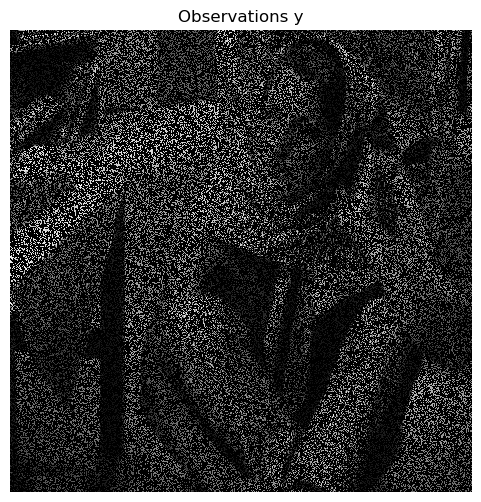

In [95]:
#display it
plt.figure(figsize = (6,6))
imageplot(y, 'Observations y')

In [96]:
Psi = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=0)
PsiS = lambda f: perform_wavelet_transf(f, Jmin, +1, ti=0)

In [97]:
SoftThresh = lambda x, T: x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))
SoftThreshPsi = lambda f, T: Psi(SoftThresh(PsiS(f), T))

In [98]:
Jmax = np.log2(n)-1
Jmin = (Jmax-3)

In [99]:
lambd = .03
ProjC = lambda f, Omega: Omega*f + (1-Omega)*y
fSpars = y
fSpars = ProjC(fSpars, Omega)
fSpars = SoftThreshPsi(fSpars, lambd)

In [100]:
#Compute the scaling factor (inverse of the redundancy).
J = Jmax-Jmin + 1
u = np.hstack(([4**(-J)], 4**(-np.floor(np.arange(J + 2./3,1,-1./3)))))
U = np.transpose(np.tile(u, (n,n,1)),(2,0,1))

In [101]:
#Choose a value of the regularization parameter.
lambd = .01

#Shortcut for the wavelet transform and the reconstruction.
Xi = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=1)
PsiS = lambda f: perform_wavelet_transf(f, Jmin, + 1, ti=1)
Psi = lambda a: Xi(a/U)

# step size

tau = 1.9*np.min(u)

#Initialize the wavelet coefficients with those of the previous reconstruction.

a = U*PsiS(fSpars)
#Gradient descent.

fTI = Psi(a)
a = a + tau*PsiS(Phi(y-Phi(fTI, Omega), Omega))

#Soft threshold.
a = SoftThresh(a, lambd*tau)

Performing the iterative soft thresholding, while monitoring the energy :

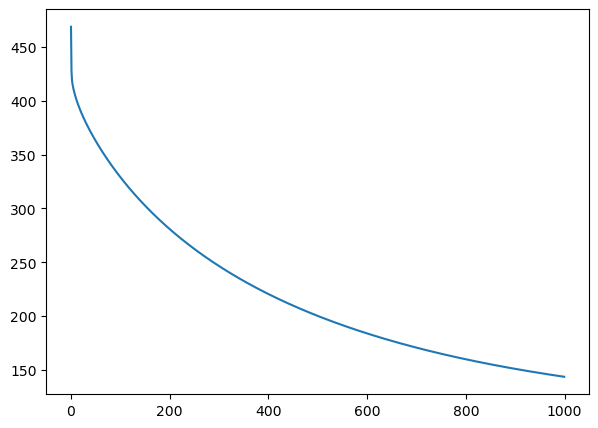

In [102]:
niter = 1000
a = U*PsiS(fSpars)
E = []
for i in range(niter):
    fTI = Psi(a)
    d = y-Phi(fTI, Omega)
    E = E + [1/2*linalg.norm(d , 'fro')**2 + lambd*np.sum(abs(a))]
    # step 
    a = SoftThresh(a + tau*PsiS(Phi(d, Omega)), lambd*tau)

plt.figure(figsize=(7,5))    
plt.plot(E)
plt.show()

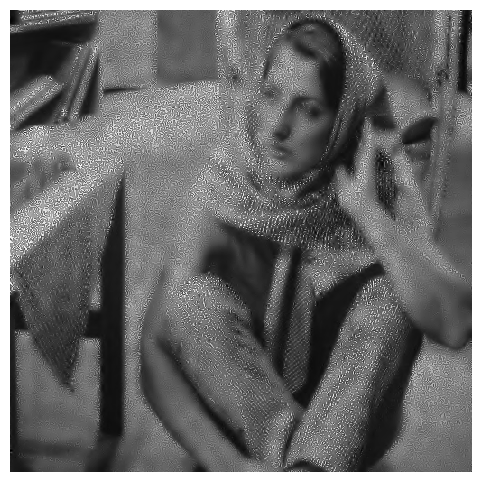

In [103]:
#Perform the reconstruction.
fTI = Psi(a)
#Display the result.
plt.figure(figsize=(6,6))
imageplot(clamp(fTI))

Now in each iteration we will use a decaying value of lambda:

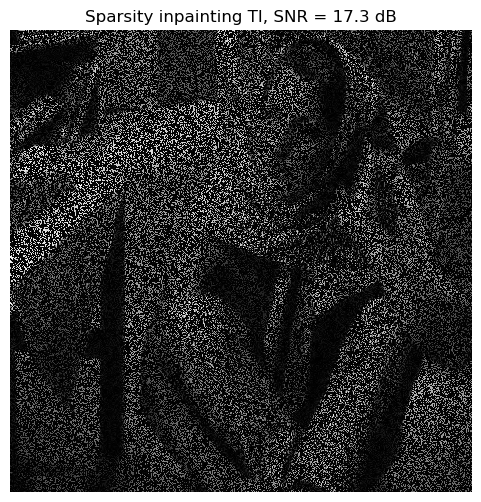

In [104]:
niter = 3000
lambda_list = np.linspace(.03, 0, niter)
err = []

for i in range(niter):
    fTI = Psi(a)
    d = y-Phi(fTI, Omega)
    #step
    a = SoftThresh(a + tau*PsiS(Phi(d, Omega)) , lambda_list[i]*tau) 


snr= 20 * np.log10(pylab.norm(f0) / pylab.norm(f0 - fTI))  

plt.figure(figsize=(6,6))
imageplot(clamp(fSpars), "Sparsity inpainting TI, SNR = %.1f dB" %snr)

### 3 Inpainting using iterative hard thesholding

Defining a vectorializwed hard thresholding:

In [105]:
HardThresh = lambda x, t: x*(abs(x) > t)

In [106]:
#Number of iterations.
niter = 500

#List of thresholds. One must start by a large enough initial threshold.
lambda_list = np.linspace(1, 0, niter)

#Initialization.
fHard = y
#Gradient descent.
fHard = ProjC(fHard, Omega)
#Hard threshold (here λ=λ0) is used).
fHard = Xi(HardThresh(PsiS(fHard), tau*lambda_list[1]))

Performing each iteration with a decaying value of lambda:

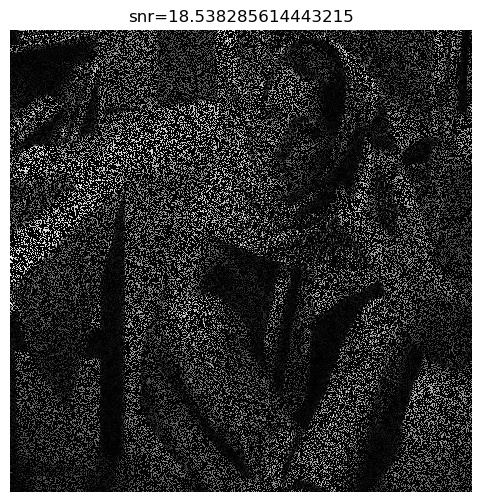

In [107]:
lambda_list = np.linspace(1, 0, niter)
#damaged observations
fHard = y

for i in range(niter):
    fHard = Xi(HardThresh(PsiS(ProjC(fHard, Omega)), lambda_list[i]))

snr= 20 * np.log10(pylab.norm(f0) / pylab.norm(f0 - fHard))      
plt.figure(figsize=(6,6))
imageplot(clamp(fSpars), "Inpainting hard thresh., SNR = %.1f dB" %snr(f0, fHard))

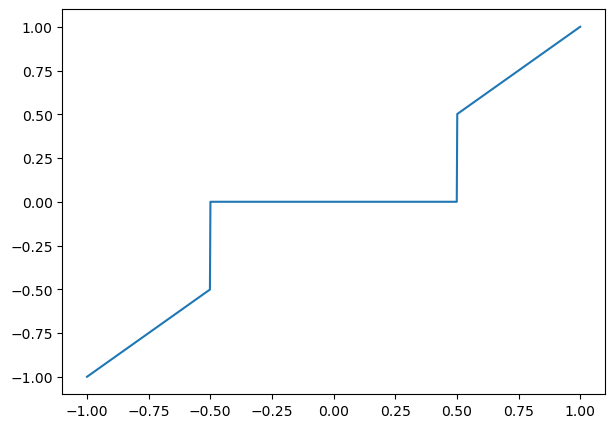

In [108]:
# Display the Hard thresholding.
x = np.linspace(-1, 1, 1000)

plt.figure(figsize=(7,5))
plt.plot(x, HardThresh(x, .5))
plt.show()

### 4 Inpainting using Othogonal Wavelet Sparsity

In [34]:
#Threhsold value
lambd = .03

In [35]:
# Gradient descent step, a projection on the inpainting constraint:
ProjC = lambda f, Omega: Omega*f + (1-Omega)*y

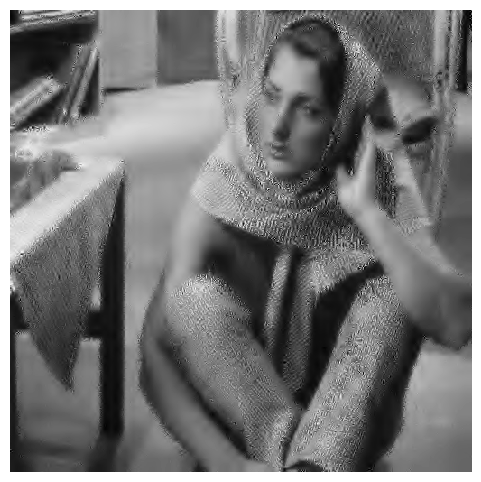

In [36]:
iterations=200
#initialize the iterations
fSpars = y 

for i in range(iterations):
    fSpars = ProjC(fSpars, Omega) # First step: gradient descent.
    fSpars = SoftThreshPsi(fSpars, lambd) # Second step: denoise the solution by thresholding.
    
plt.figure(figsize=(6,6))
imageplot(clamp(fSpars))

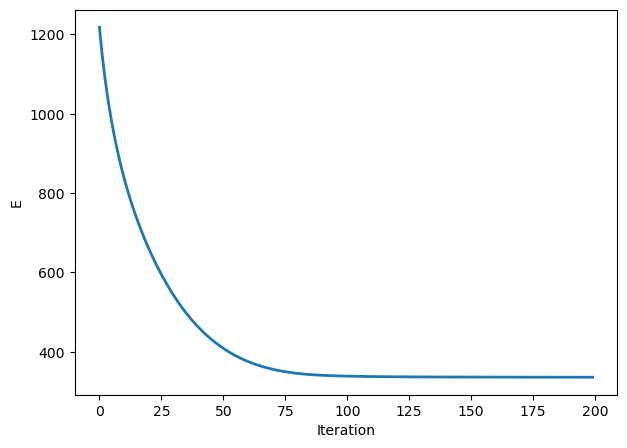

In [39]:
lambd=.03
fSpars = y
energy = []
niter = 200
for i in range(niter):
    fSpars = SoftThreshPsi(ProjC(fSpars, Omega), lambd)
    # record the energy
    fW = PsiS(fSpars)
    energy = energy + [1/2*linalg.norm(y-Phi(fSpars, Omega),"fro")**2 + lambd*np.sum(abs(fW))]
    
plt.figure(figsize=(7,5))
plt.plot(energy, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("E")
plt.show()

Display the image:

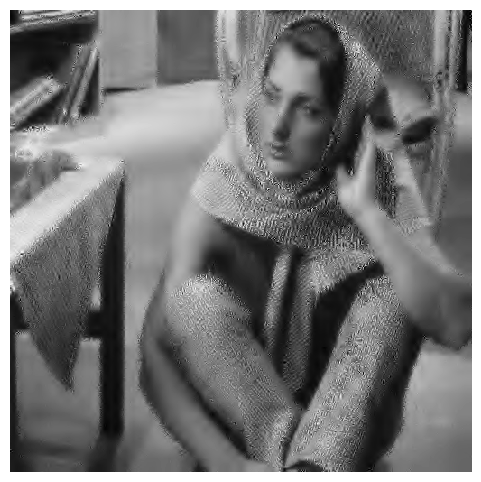

In [40]:
plt.figure(figsize=(6,6))
imageplot(clamp(fSpars))

Since we don't have any noise, we can decay the value of lambda through iterations to make it tend to 0:

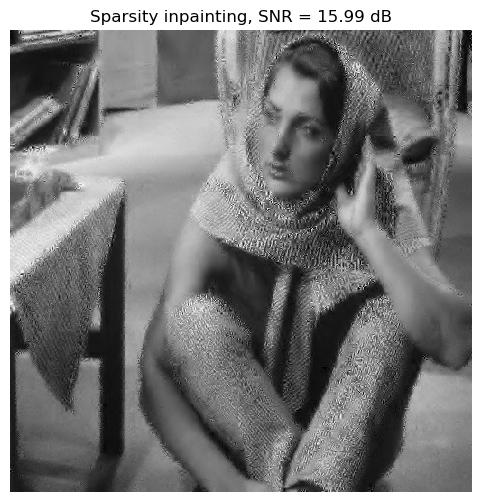

In [48]:
niter = 200
lambda_list = np.linspace(.03, 0, niter)
err = []

for i in range(niter):
    fSpars = SoftThreshPsi(ProjC(fSpars, Omega), lambda_list[i])
    
plt.figure(figsize=(6,6))
snrr= 20 * np.log10(pylab.norm(f0) / pylab.norm(f0 - fSpars))  
snrr= np.round(snrr, 2)

imageplot(clamp(fSpars), f"Sparsity inpainting, SNR = {snrr} dB" )

### 5 Varying the lambda parameter

Here we implement the warm restart FISTA algorithm in order to see the impact of Lambda

In [24]:
iterations = 50

In [25]:
def FISTA_WarmRestart(snr):
    """
    Apply the FISTA algorithm with warm restarts for denoising.

    Parameters:
    - snr: Signal-to-noise ratio
    - noisy_images: Dictionary containing noisy images indexed by their snr
    - A: Linear operator
    - SoftThreshPsi: Soft thresholding function in Psi (wavelet) domain
    - PsiS: Wavelet transform function
    - Psi: Inverse wavelet transform function
    - rescale: Rescaling function for images

    Returns:
    None. Displays denoised image.
    """
    
    n = 512
    f0 = cv2.imread("barbara.jpg", cv2.IMREAD_GRAYSCALE)
    f0 = rescale(f0[256 - n//2 : 256 + n//2, 256 - n//2 : 256 + n//2])

    # Initialize parameters
    niter = 50
    lambda_list = np.linspace(0.03, 0, niter)

    alpha = np.zeros_like(f0)
    z = np.zeros_like(f0)

    # Iterate over the lambda values
    for lambd in lambda_list:
        z = alpha.copy()
        
        # FISTA iterations
        for i in range(iterations):
            a = SoftThreshPsi(z + PsiS(A * (corrupted_images_dict[snr] - A * Psi(z))), lambd)
            z = a + (i / (i + 5)) * (a - alpha)
            alpha = a

    denoised = Psi(alpha)
    error = pylab.norm(f0 - denoised)

    # Compute the new SNR
    snr_new = 20 * np.log10(pylab.norm(f0) / error)
    
    # Plotting results
    plt.figure(figsize=(6, 6))
    imageplot(clamp(denoised), f"Sparsity inpainting for image with snr level {snr}, SNR = {snr_new:.1f} dB")


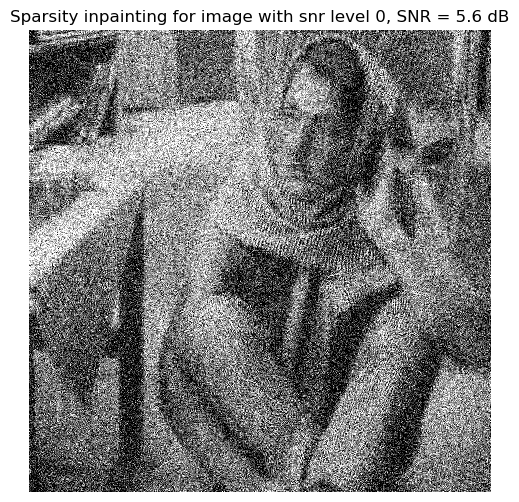

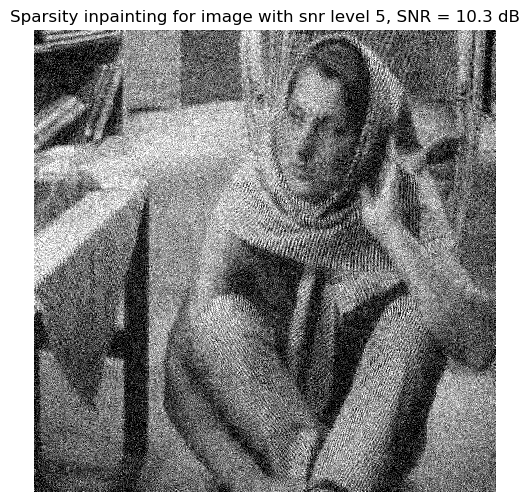

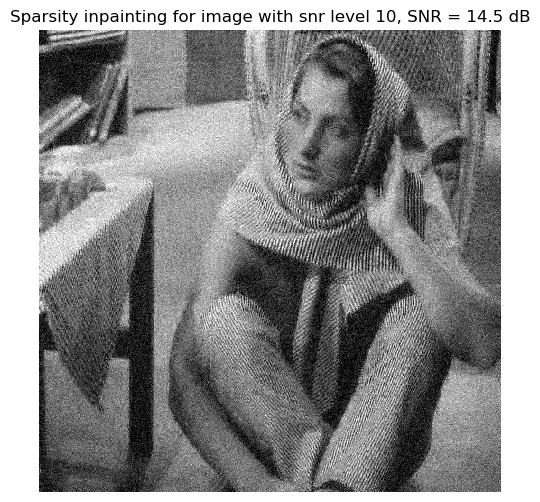

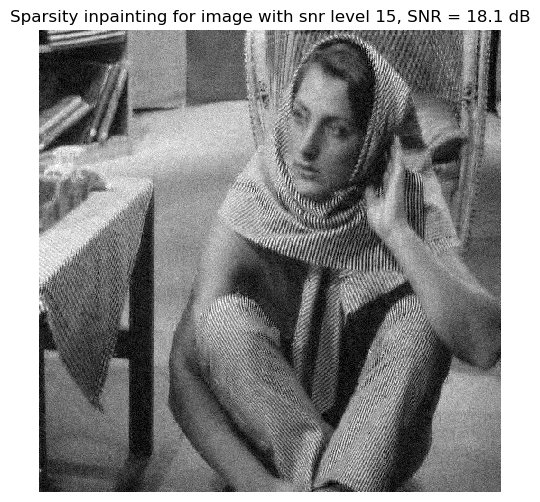

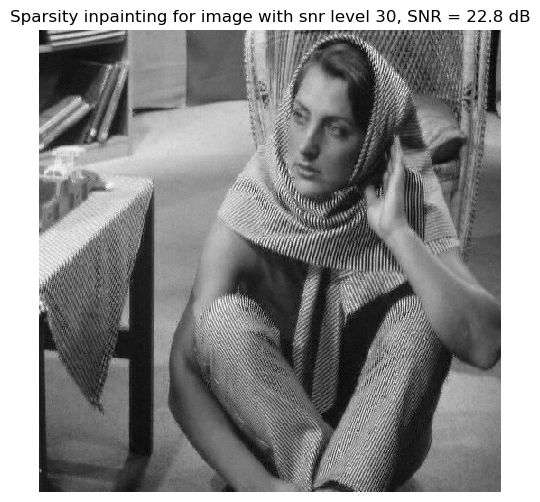

In [23]:
for snr in SNR_LEVELS:
    FISTA_WarmRestart(snr)